In [12]:
import pandas as pd
from sklearn.metrics import accuracy_score, matthews_corrcoef

# 读取人类标注的文件
human_file = "evaluate_MEU/experiment_1/evaluate_GT/北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理.xlsx"
human_df = pd.read_excel(human_file)

# 1. 删除'Law'列值为'blank'的行
human_df = human_df[human_df['Law'] != 'blank']

# 2. 取出需要的列
human_df = human_df[['GT_MEU_id', 'been_responsed_by', 'state', 'comments']]

# 读取AI标注的文件
ai_file = "evaluate_MEU/experiment_1/北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理_0.xlsx"
ai_df = pd.read_excel(ai_file)
ai_df['state'] = ai_df['state'].map({'correct': 1, 'wrong': 0})
ai_df['GT_MEU_id'] = ai_df['MEU_id']
ai_df.drop(['MEU_id'], axis=1)


# 合并两个DataFrame，基于GT_MEU_id
merged_df = pd.merge(human_df, ai_df, on='GT_MEU_id', suffixes=('_human', '_ai'))
merged_df['been_responsed_by_human'] = merged_df['been_responsed_by_human'].str.replace(';', ',')  

merged_df.columns

Index(['GT_MEU_id', 'been_responsed_by_human', 'state_human', 'comments_human',
       'law_n', 'MEU_id', 'been_responsed_by_ai', 'state_ai', 'comments_ai'],
      dtype='object')

In [13]:
def add_gen_prefix(value):
    if pd.isna(value) or value == '':
        return value
    
    # 处理并列情况，用逗号分隔
    parts = [part.strip() for part in str(value).split(',')]
    
    processed_parts = []
    for part in parts:
        if not part.startswith('Gen_'):
            # 确保在开头添加Gen_，同时避免重复添加
            processed_part = 'Gen_' + part
            processed_parts.append(processed_part)
        else:
            processed_parts.append(part)
    
    # 重新组合成字符串
    return ','.join(processed_parts)

# 应用处理函数到列
merged_df['been_responsed_by_ai'] = merged_df['been_responsed_by_ai'].apply(add_gen_prefix)

In [14]:
merged_df['been_responsed_by_human'].iloc[75]

'Gen_MEU_21_2,Gen_MEU_21_3'

## state的一致性

In [15]:
import pandas as pd
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix
from scipy.stats import spearmanr


# 比较state的一致性
human_states = merged_df['state_human']
ai_states = merged_df['state_ai']

# 计算准确率
accuracy = accuracy_score(human_states, ai_states)

# 计算马修斯相关系数
mcc = matthews_corrcoef(human_states, ai_states)

# 计算Spearman相关系数
spearman_corr, spearman_p = spearmanr(human_states, ai_states)

# 计算混淆矩阵
conf_matrix = confusion_matrix(human_states, ai_states)

# 打印结果
print(f"Human认为的准确率: {human_states.mean():.4f}")
print(f"Ai认为的准确率: {ai_states.mean():.4f}")

print(f"以人类为GT, AI评估的准确率(Accuracy): {accuracy:.4f}")
print(f"人类评估和AI评估的 马修斯相关系数(MCC): {mcc:.4f}")
print(f"人类评估和AI评估的 Spearman相关系数: {spearman_corr:.4f} (p-value: {spearman_p:.4g})")
print("\n混淆矩阵:")
print(conf_matrix)

# 输出不一致的样本
disagreements = merged_df[merged_df['state_human'] != merged_df['state_ai']]
print("\n不一致的样本:")
disagreements[['GT_MEU_id', 'state_human', 'state_ai', 'comments_human', 'comments_ai']]

Human认为的准确率: 0.6916
Ai认为的准确率: 0.6822
以人类为GT, AI评估的准确率(Accuracy): 0.9159
人类评估和AI评估的 马修斯相关系数(MCC): 0.8047
人类评估和AI评估的 Spearman相关系数: 0.8047 (p-value: 1.622e-25)

混淆矩阵:
[[29  4]
 [ 5 69]]

不一致的样本:


,GT_MEU_id,state_human,state_ai,comments_human,comments_ai
31,GT_MEU_9_3,0.0,1,"condition遗漏了""公司上市时未盈利的""",条件与约束的语义完全覆盖原GT_MEU要求
43,GT_MEU_12_2,0.0,1,但书条款处理错误,Gen_MEU_12_1的约束条件二完整覆盖GT_MEU_12_2的净资产要求，且条件拆分符...
44,GT_MEU_12_3,0.0,1,但书条款处理错误,Gen_MEU_12_1的约束条件三完整覆盖净利润为负的约束，条件拆分符合逻辑
49,GT_MEU_13_3,1.0,0,NaN,Gen_MEU的condition遗漏了'且处于减持后6个月内'的关键时间条件，导致约束触发...
69,GT_MEU_18_4,1.0,0,NaN,将权益分派场景的计算规则错误转化为约束条件
70,GT_MEU_19_1,1.0,0,NaN,Gen_MEU的subject缺失，虽然contextual_info包含相关内容，但未明确...
73,GT_MEU_21_1,0.0,1,"对应Gen_MEU应当拆开成两个来写, 不应当把后者放入contextual_info",主体、条件和约束内容完全匹配
98,GT_MEU_25_7,1.0,0,NaN,缺少contextual_info对'前述主体'的定义，导致主体范围不明确
101,GT_MEU_26_2,1.0,0,NaN,Gen_MEU_26_2添加了'持有特定类型账户'的条件，导致约束范围缩小，与原MEU的无条...


## been_responsed_by 的一致性

In [16]:
import pandas as pd

# Function to compare two semicolon-separated strings
def compare_responses(human_str, ai_str):
    if pd.isna(human_str) or pd.isna(ai_str):
        return False
    
    human_set = set(human_str.split(';'))
    ai_set = set(ai_str.split(';'))
    
    return human_set == ai_set

# Apply the comparison to each row
merged_df['response_match'] = merged_df.apply(
    lambda row: compare_responses(row['been_responsed_by_human'], row['been_responsed_by_ai']),
    axis=1
)

# Calculate overall consistency
consistency_rate = merged_df['response_match'].mean()
total_comparisons = len(merged_df)
matching_cases = merged_df['response_match'].sum()
non_matching_cases = total_comparisons - matching_cases

# Display results
print(f"Consistency Analysis Results:")
print(f"Total comparisons: {total_comparisons}")
print(f"Matching cases: {matching_cases} ({consistency_rate:.2%})")
print(f"Non-matching cases: {non_matching_cases} ({(1-consistency_rate):.2%})")

# Show non-matching cases for inspection
if non_matching_cases > 0:
    print("\nNon-matching cases:")
    display(merged_df[~merged_df['response_match']][['been_responsed_by_human', 'been_responsed_by_ai']])
else:
    print("\nAll cases match perfectly!")

Consistency Analysis Results:
Total comparisons: 107
Matching cases: 95 (88.79%)
Non-matching cases: 12 (11.21%)

Non-matching cases:


,been_responsed_by_human,been_responsed_by_ai
9,Gen_MEU_4_1,NaN
10,Gen_MEU_4_1,NaN
11,Gen_MEU_4_1,NaN
12,Gen_MEU_4_1,NaN
13,Gen_MEU_4_1,NaN
19,Gen_MEU_5_1,NaN
20,Gen_MEU_5_1,NaN
21,Gen_MEU_5_1,NaN
42,Gen_MEU_12_1,"Gen_MEU_12_1,Gen_MEU_12_2"
57,Gen_MEU_14_8,NaN


# AI与自己的一致性

In [17]:
# 读取AI标注的文件
ai_file = "evaluate_MEU/experiment_1/北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理_0.xlsx"
ai_df = pd.read_excel(ai_file)
ai_df .columns

Index(['law_n', 'MEU_id', 'been_responsed_by', 'state', 'comments'], dtype='object')

In [18]:
import pandas as pd
import os
import re
from collections import defaultdict

# 定义文件夹路径
folder_path = "evaluate_MEU/experiment_1"

# 使用正则表达式匹配文件名模式
pattern = re.compile(r"北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理_(\d+)\.xlsx")

# 存储所有实验数据 {meu_id: {exp_num: state}}
experiment_data = defaultdict(dict)

# 遍历文件夹，找出所有匹配的实验文件
for filename in os.listdir(folder_path):
    match = pattern.fullmatch(filename)
    if match:
        exp_num = int(match.group(1))  # 提取实验编号
        file_path = os.path.join(folder_path, filename)
        
        try:
            df = pd.read_excel(file_path)
            # 验证必要的列是否存在
            required_columns = ['law_n', 'MEU_id', 'been_responsed_by', 'state', 'comments']
            if not all(col in df.columns for col in required_columns):
                print(f"警告: 文件 {filename} 缺少必要的列，跳过处理")
                continue
                
            # 记录本次实验的数据
            for _, row in df.iterrows():
                experiment_data[row['MEU_id']][exp_num] = row['state']
                
        except Exception as e:
            print(f"处理文件 {filename} 时出错: {str(e)}")
            continue

# 检查一致性
consistent_meus = []
inconsistent_meus = []

for meu_id, states in experiment_data.items():
    unique_states = set(states.values())
    if len(unique_states) == 1:
        consistent_meus.append((meu_id, next(iter(unique_states))))
    else:
        # 收集不一致的状态及其出现次数
        state_counts = defaultdict(int)
        for state in states.values():
            state_counts[state] += 1
        inconsistent_meus.append((meu_id, dict(state_counts)))

# 输出统计结果
total_experiments = len({exp_num for states in experiment_data.values() for exp_num in states})
print(f"分析完成，共找到 {total_experiments} 次实验")
print(f"总MEU数量: {len(experiment_data)}")
print(f"一致分配的MEU数量: {len(consistent_meus)} ({len(consistent_meus)/len(experiment_data):.1%})")
print(f"不一致分配的MEU数量: {len(inconsistent_meus)} ({len(inconsistent_meus)/len(experiment_data):.1%})")

# 输出不一致的MEU详情（按不一致程度排序）
if inconsistent_meus:
    print("\n不一致的MEU详情（按不一致程度降序）:")
    # 按不一致程度排序（出现最多状态的次数占比）
    inconsistent_meus_sorted = sorted(
        inconsistent_meus,
        key=lambda x: max(x[1].values())/sum(x[1].values()),
        reverse=True
    )
    
    for meu_id, state_counts in inconsistent_meus_sorted:
        total = sum(state_counts.values())
        print(f"\nMEU_ID: {meu_id}")
        for state, count in sorted(state_counts.items(), key=lambda x: x[1], reverse=True):
            print(f"  State '{state}': {count}/{total} 次 ({count/total:.1%})")

# # 可选：保存结果到文件
# output_file = "MEU_state_consistency_report.txt"
# with open(output_file, 'w', encoding='utf-8') as f:
#     f.write("MEU状态一致性分析报告\n")
#     f.write("="*50 + "\n")
#     f.write(f"总实验次数: {total_experiments}\n")
#     f.write(f"总MEU数量: {len(experiment_data)}\n")
#     f.write(f"一致分配的MEU数量: {len(consistent_meus)} ({len(consistent_meus)/len(experiment_data):.1%})\n")
#     f.write(f"不一致分配的MEU数量: {len(inconsistent_meus)} ({len(inconsistent_meus)/len(experiment_data):.1%})\n")
    
#     if inconsistent_meus:
#         f.write("\n不一致的MEU详情:\n")
#         for meu_id, state_counts in inconsistent_meus_sorted:
#             total = sum(state_counts.values())
#             f.write(f"\nMEU_ID: {meu_id}\n")
#             for state, count in sorted(state_counts.items(), key=lambda x: x[1], reverse=True):
#                 f.write(f"  State '{state}': {count}/{total} 次 ({count/total:.1%})\n")

# print(f"\n详细报告已保存到: {output_file}")

分析完成，共找到 5 次实验
总MEU数量: 107
一致分配的MEU数量: 92 (86.0%)
不一致分配的MEU数量: 15 (14.0%)

不一致的MEU详情（按不一致程度降序）:

MEU_ID: GT_MEU_4_9
  State 'correct': 4/5 次 (80.0%)
  State 'wrong': 1/5 次 (20.0%)

MEU_ID: GT_MEU_10_1
  State 'wrong': 4/5 次 (80.0%)
  State 'correct': 1/5 次 (20.0%)

MEU_ID: GT_MEU_10_2
  State 'wrong': 4/5 次 (80.0%)
  State 'correct': 1/5 次 (20.0%)

MEU_ID: GT_MEU_11_1
  State 'correct': 4/5 次 (80.0%)
  State 'wrong': 1/5 次 (20.0%)

MEU_ID: GT_MEU_11_2
  State 'correct': 4/5 次 (80.0%)
  State 'wrong': 1/5 次 (20.0%)

MEU_ID: GT_MEU_12_2
  State 'wrong': 4/5 次 (80.0%)
  State 'correct': 1/5 次 (20.0%)

MEU_ID: GT_MEU_18_4
  State 'wrong': 4/5 次 (80.0%)
  State 'correct': 1/5 次 (20.0%)

MEU_ID: GT_MEU_19_1
  State 'wrong': 4/5 次 (80.0%)
  State 'correct': 1/5 次 (20.0%)

MEU_ID: GT_MEU_24_4
  State 'wrong': 4/5 次 (80.0%)
  State 'correct': 1/5 次 (20.0%)

MEU_ID: GT_MEU_12_3
  State 'wrong': 3/5 次 (60.0%)
  State 'correct': 2/5 次 (40.0%)

MEU_ID: GT_MEU_13_1
  State 'correct': 3/5 次 (60.0%)
 

In [19]:
import pandas as pd
import os
import re
from collections import defaultdict

# 定义文件夹路径
folder_path = "evaluate_MEU/experiment_1"

# 使用正则表达式匹配文件名模式
pattern = re.compile(r"北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理_(\d+)\.xlsx")

# 存储所有实验数据 {exp_num: {meu_id: state}}
experiment_states = defaultdict(dict)

# 遍历文件夹，找出所有匹配的实验文件
for filename in os.listdir(folder_path):
    match = pattern.fullmatch(filename)
    if match:
        exp_num = int(match.group(1))  # 提取实验编号
        file_path = os.path.join(folder_path, filename)
        
        try:
            df = pd.read_excel(file_path)
            # 验证必要的列是否存在
            required_columns = ['law_n', 'MEU_id', 'been_responsed_by', 'state', 'comments']
            if not all(col in df.columns for col in required_columns):
                print(f"警告: 文件 {filename} 缺少必要的列，跳过处理")
                continue
                
            # 记录本次实验的数据
            for _, row in df.iterrows():
                experiment_states[exp_num][row['MEU_id']] = row['state']
                
        except Exception as e:
            print(f"处理文件 {filename} 时出错: {str(e)}")
            continue

if not experiment_states:
    print("没有找到任何实验数据！")
    exit()

# 确定基准实验（第0次实验）
baseline_exp = min(experiment_states.keys())
print(f"基准实验确定为: 实验 {baseline_exp}")

# 获取所有MEU_id的集合
all_meu_ids = set()
for exp_num, states in experiment_states.items():
    all_meu_ids.update(states.keys())

# 按实验编号排序
sorted_exp_nums = sorted(experiment_states.keys())

# 存储每个实验后的不一致MEU
incremental_inconsistencies = {}
cumulative_inconsistent_meus = set()
baseline_states = experiment_states[baseline_exp]

# 初始化基准实验的统计
incremental_inconsistencies[baseline_exp] = {
    'new_inconsistent': 0,
    'cumulative_inconsistent': 0,
    'consistency_ratio': 1.0
}

# 分析每个后续实验
for exp_num in sorted_exp_nums:
    if exp_num == baseline_exp:
        continue  # 跳过基准实验
    
    current_states = experiment_states[exp_num]
    new_inconsistent = 0
    
    for meu_id in all_meu_ids:
        # 只考虑在基准实验和当前实验中都存在的MEU
        if meu_id in baseline_states and meu_id in current_states:
            if baseline_states[meu_id] != current_states[meu_id]:
                if meu_id not in cumulative_inconsistent_meus:
                    new_inconsistent += 1
                    cumulative_inconsistent_meus.add(meu_id)
    
    total_valid_meus = len([meu_id for meu_id in all_meu_ids if meu_id in baseline_states])
    current_consistent = total_valid_meus - len(cumulative_inconsistent_meus)
    consistency_ratio = current_consistent / total_valid_meus if total_valid_meus > 0 else 0
    
    incremental_inconsistencies[exp_num] = {
        'new_inconsistent': new_inconsistent,
        'cumulative_inconsistent': len(cumulative_inconsistent_meus),
        'consistency_ratio': consistency_ratio
    }

# 输出增量分析结果
print("\n增量不一致性分析报告:")
print("=" * 60)
print(f"基准实验 ({baseline_exp}): 100.0% 一致 (0 新增不一致)")

for exp_num in sorted(incremental_inconsistencies.keys()):
    if exp_num == baseline_exp:
        continue
    
    stats = incremental_inconsistencies[exp_num]
    print(f"实验 {exp_num}:")
    print(f"  新增不一致MEU: {stats['new_inconsistent']}")
    print(f"  累计不一致MEU: {stats['cumulative_inconsistent']}")
    print(f"  当前一致比例: {stats['consistency_ratio']:.1%}")
    print("-" * 40)

# 可视化结果（简单文本图表）
print("\n一致比例变化趋势:")
for exp_num in sorted(incremental_inconsistencies.keys()):
    stats = incremental_inconsistencies[exp_num]
    if exp_num == baseline_exp:
        print(f"实验 {exp_num}: |{'█' * 50}| 100.0%")
    else:
        bar_length = int(50 * stats['consistency_ratio'])
        print(f"实验 {exp_num}: |{'█' * bar_length}{' ' * (50 - bar_length)}| {stats['consistency_ratio']:.1%} "
              f"(新增 {stats['new_inconsistent']} 不一致)")

# # 保存详细报告
# report_file = "incremental_consistency_report.txt"
# with open(report_file, 'w', encoding='utf-8') as f:
#     f.write("增量一致性分析报告\n")
#     f.write("=" * 60 + "\n")
#     f.write(f"基准实验: {baseline_exp}\n")
#     f.write(f"总MEU数量: {len(all_meu_ids)}\n\n")
    
#     f.write("实验进展:\n")
#     for exp_num in sorted(incremental_inconsistencies.keys()):
#         stats = incremental_inconsistencies[exp_num]
#         if exp_num == baseline_exp:
#             f.write(f"实验 {exp_num} (基准): 100.0% 一致\n")
#         else:
#             f.write(f"实验 {exp_num}:\n")
#             f.write(f"  新增不一致MEU: {stats['new_inconsistent']}\n")
#             f.write(f"  累计不一致MEU: {stats['cumulative_inconsistent']}\n")
#             f.write(f"  当前一致比例: {stats['consistency_ratio']:.1%}\n")
#         f.write("-" * 40 + "\n")
    
#     f.write("\n不一致MEU列表:\n")
#     for meu_id in sorted(cumulative_inconsistent_meus):
#         f.write(f"\nMEU_ID: {meu_id}")
#         f.write(f"\n  基准状态: {baseline_states.get(meu_id, 'N/A')}")
#         for exp_num in sorted(experiment_states.keys()):
#             if exp_num != baseline_exp and meu_id in experiment_states[exp_num]:
#                 current_state = experiment_states[exp_num][meu_id]
#                 if current_state != baseline_states.get(meu_id):
#                     f.write(f"\n  实验 {exp_num}: {current_state}")

# print(f"\n详细报告已保存到: {report_file}")

基准实验确定为: 实验 0

增量不一致性分析报告:
基准实验 (0): 100.0% 一致 (0 新增不一致)
实验 1:
  新增不一致MEU: 9
  累计不一致MEU: 9
  当前一致比例: 91.6%
----------------------------------------
实验 2:
  新增不一致MEU: 3
  累计不一致MEU: 12
  当前一致比例: 88.8%
----------------------------------------
实验 3:
  新增不一致MEU: 1
  累计不一致MEU: 13
  当前一致比例: 87.9%
----------------------------------------
实验 4:
  新增不一致MEU: 2
  累计不一致MEU: 15
  当前一致比例: 86.0%
----------------------------------------

一致比例变化趋势:
实验 0: |██████████████████████████████████████████████████| 100.0%
实验 1: |█████████████████████████████████████████████     | 91.6% (新增 9 不一致)
实验 2: |████████████████████████████████████████████      | 88.8% (新增 3 不一致)
实验 3: |███████████████████████████████████████████       | 87.9% (新增 1 不一致)
实验 4: |██████████████████████████████████████████        | 86.0% (新增 2 不一致)


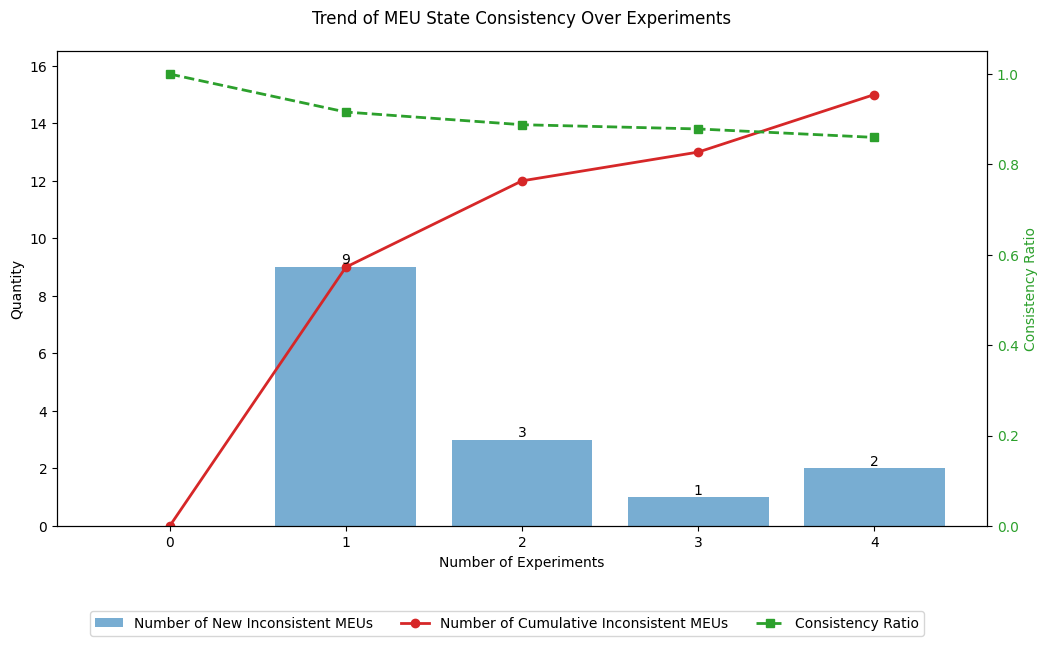

In [20]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data
exp_numbers = sorted(incremental_inconsistencies.keys())
cumulative_inconsistent = [incremental_inconsistencies[exp]['cumulative_inconsistent'] for exp in exp_numbers]
new_inconsistent = [incremental_inconsistencies[exp]['new_inconsistent'] for exp in exp_numbers]
consistency_ratios = [incremental_inconsistencies[exp]['consistency_ratio'] for exp in exp_numbers]

# Create figure and dual axes
fig, ax1 = plt.subplots(figsize=(12, 6.5))  # 略微减小高度

# Set primary axis (left, quantity)
color1 = 'tab:red'
color2 = 'tab:blue'
ax1.set_xlabel('Number of Experiments')
ax1.set_ylabel('Quantity', color='black')
ax1.set_xticks(exp_numbers)

# Plot bar chart (new inconsistencies)
bars = ax1.bar(exp_numbers, new_inconsistent, color=color2, alpha=0.6, label='Number of New Inconsistent MEUs')
# Plot line chart (cumulative inconsistencies)
line1 = ax1.plot(exp_numbers, cumulative_inconsistent, 
                color=color1, marker='o', linewidth=2, label='Number of Cumulative Inconsistent MEUs')[0]
ax1.tick_params(axis='y')
ax1.set_ylim(0, max(cumulative_inconsistent)*1.1)

# Add data labels for bars
for bar in bars:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height}', ha='center', va='bottom')

# Create secondary axis (right, ratio)
ax2 = ax1.twinx()
color3 = 'tab:green'
line2 = ax2.plot(exp_numbers, consistency_ratios, 
                color=color3, marker='s', linestyle='--', linewidth=2, label='Consistency Ratio')[0]
ax2.set_ylabel('Consistency Ratio', color=color3)
ax2.tick_params(axis='y', labelcolor=color3)
ax2.set_ylim(0, 1.05)
ax2.grid(False)

# Combine all lines and bars for a single legend
lines = [bars.patches[0], line1, line2]
labels = ['Number of New Inconsistent MEUs', 
          'Number of Cumulative Inconsistent MEUs', 
          'Consistency Ratio']

# 将图例放在图表下方，调整位置使其更靠近图表
plt.legend(lines, labels, 
          loc='upper center',
          bbox_to_anchor=(0.5, 0.03), 
          ncol=3,
          bbox_transform=fig.transFigure)

# Add title and adjust layout
plt.title('Trend of MEU State Consistency Over Experiments', pad=20)

# 调整布局，减小底部边距
plt.subplots_adjust(bottom=0.15)  # 从0.2减小到0.15

# Display the plot
plt.show()

# 多次AI与人的一致性

AI-Human Consistency Analysis Report

Summary Statistics Across All Experiments:
 experiment  accuracy      mcc  spearman_corr   spearman_p  response_consistency  total_comparisons  state_disagreements  response_disagreements
          0  0.915888 0.804657       0.804657 1.622304e-25              0.887850                107                    9                      12
          1  0.887850 0.755648       0.755648 5.161448e-21              0.897196                107                   12                      11
          2  0.897196 0.766506       0.766506 6.471653e-22              0.906542                107                   11                      10
          3  0.915888 0.809334       0.809334 5.177604e-26              0.934579                107                    9                       7
          4  0.915888 0.815286       0.815286 1.155628e-26              0.925234                107                    9                       8



Experiment 0 Results:
------------------------

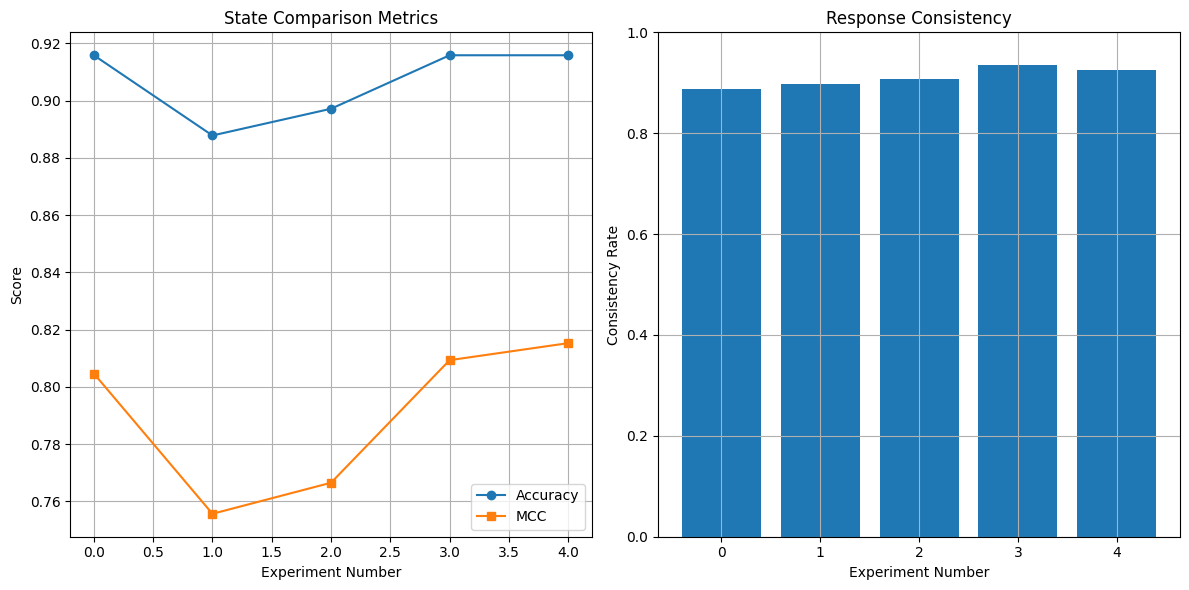

In [22]:
import pandas as pd
import os
import re
from sklearn.metrics import accuracy_score, matthews_corrcoef, confusion_matrix
from scipy.stats import spearmanr
from collections import defaultdict
from pathlib import Path

# Configuration
human_file = "evaluate_MEU/experiment_1/evaluate_GT/北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理.xlsx"
experiment_dir = "evaluate_MEU/experiment_1"
file_pattern = r"北京证券交易所上市公司持续监管指引第8号——股份减持和持股管理_(\d+)\.xlsx"

# Improved file discovery using pathlib
def find_ai_experiment_files(directory, pattern):
    """Find all AI experiment files matching the pattern in the directory"""
    files = []
    compiled_pattern = re.compile(pattern)
    
    for file in Path(directory).iterdir():
        if file.is_file():
            match = compiled_pattern.fullmatch(file.name)
            if match:
                exp_num = int(match.group(1))
                files.append((exp_num, str(file)))
    
    return sorted(files, key=lambda x: x[0])

# Find all AI experiment files
ai_files = find_ai_experiment_files(experiment_dir, file_pattern)
if not ai_files:
    raise ValueError("No AI experiment files found matching the pattern")

# Process each AI experiment
results = []
detailed_comparisons = []

for exp_num, ai_path in sorted(ai_files, key=lambda x: x[0]):
    # Load and preprocess AI results
    ai_df = pd.read_excel(ai_path)
    ai_df['state'] = ai_df['state'].map({'correct': 1, 'wrong': 0})
    ai_df['GT_MEU_id'] = ai_df['MEU_id']
    ai_df = ai_df.drop(['MEU_id'], axis=1)
    
    # Merge with human annotations
    merged_df = pd.merge(human_df, ai_df, on='GT_MEU_id', suffixes=('_human', '_ai'))
    
    # Process been_responsed_by_ai column
    def add_gen_prefix(value):
        if pd.isna(value) or value == '':
            return value
        parts = [part.strip() for part in str(value).split(',')]
        processed_parts = ['Gen_' + part if not part.startswith('Gen_') else part for part in parts]
        return ','.join(processed_parts)
    
    merged_df['been_responsed_by_ai'] = merged_df['been_responsed_by_ai'].apply(add_gen_prefix)
    
    # State comparison metrics
    human_states = merged_df['state_human']
    ai_states = merged_df['state_ai']
    
    accuracy = accuracy_score(human_states, ai_states)
    mcc = matthews_corrcoef(human_states, ai_states)
    spearman_corr, spearman_p = spearmanr(human_states, ai_states)
    conf_matrix = confusion_matrix(human_states, ai_states)
    
    # Response comparison
    def compare_responses(human_str, ai_str):
        if pd.isna(human_str) or pd.isna(ai_str):
            return False
        human_set = set(str(human_str).split(','))
        ai_set = set(str(ai_str).split(','))
        return human_set == ai_set
    
    merged_df['response_match'] = merged_df.apply(
        lambda row: compare_responses(row['been_responsed_by_human'], row['been_responsed_by_ai']),
        axis=1
    )
    response_consistency = merged_df['response_match'].mean()
    
    # Store results
    results.append({
        'experiment': exp_num,
        'accuracy': accuracy,
        'mcc': mcc,
        'spearman_corr': spearman_corr,
        'spearman_p': spearman_p,
        'response_consistency': response_consistency,
        'confusion_matrix': conf_matrix,
        'total_comparisons': len(merged_df),
        'state_disagreements': len(merged_df[merged_df['state_human'] != merged_df['state_ai']]),
        'response_disagreements': len(merged_df[~merged_df['response_match']])
    })
    
    detailed_comparisons.append({
        'experiment': exp_num,
        'data': merged_df
    })

# Generate comprehensive report
print("="*80)
print("AI-Human Consistency Analysis Report")
print("="*80 + "\n")

# Summary statistics
summary_df = pd.DataFrame(results)
print("Summary Statistics Across All Experiments:")
print(summary_df.drop(columns=['confusion_matrix']).to_string(index=False))
print("\n")

# Detailed report for each experiment
for res in results:
    print(f"\nExperiment {res['experiment']} Results:")
    print("-"*60)
    print(f"State Comparison:")
    print(f"Accuracy: {res['accuracy']:.4f}")
    print(f"MCC: {res['mcc']:.4f}")
    print(f"Spearman Correlation: {res['spearman_corr']:.4f} (p={res['spearman_p']:.4g})")
    print(f"Confusion Matrix:\n{res['confusion_matrix']}")
    print(f"\nResponse Comparison:")
    print(f"Consistency Rate: {res['response_consistency']:.2%}")
    print(f"State Disagreements: {res['state_disagreements']}")
    print(f"Response Disagreements: {res['response_disagreements']}")
    print("-"*60)

# Visualization
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
x = [r['experiment'] for r in results]

# State accuracy
plt.subplot(1, 2, 1)
plt.plot(x, [r['accuracy'] for r in results], 'o-', label='Accuracy')
plt.plot(x, [r['mcc'] for r in results], 's-', label='MCC')
plt.xlabel('Experiment Number')
plt.ylabel('Score')
plt.title('State Comparison Metrics')
plt.legend()
plt.grid(True)

# Response consistency
plt.subplot(1, 2, 2)
plt.bar(x, [r['response_consistency'] for r in results])
plt.xlabel('Experiment Number')
plt.ylabel('Consistency Rate')
plt.title('Response Consistency')
plt.ylim(0, 1)
plt.grid(True)

plt.tight_layout()
plt.savefig('ai_human_consistency_analysis.png')
print("\nVisualization saved to 'ai_human_consistency_analysis.png'")

# Save detailed results to Excel
with pd.ExcelWriter('detailed_ai_human_comparisons.xlsx') as writer:
    for comp in detailed_comparisons:
        comp['data'].to_excel(writer, sheet_name=f"Exp_{comp['experiment']}", index=False)
print("Detailed comparisons saved to 'detailed_ai_human_comparisons.xlsx'")